# De DataFrames a Redes

Por: [Eduardo Graells-Garrido](http://datagramas.cl) (`egraells@udd.cl`)

En este notebook construiremos una red a partir de un DataFrame de `pandas`. Para eso utilizaremos la biblioteca [`networkx`](https://networkx.github.io), que es una biblioteca de redes nativa de Python. 

Leeremos los datos de la encuesta origen destino y crearemos una red de viajes entre comunas. Luego visualizaremos esta red y finalmente la guardaremos en formato `GraphML`. Este formato es un estándar para almacenar redes y puede ser leído por bibliotecas como `networkx` o `graphtool`, o bien en programas como [Gephi](https://gephi.org/).

## Preámbulo

Aquí cargamos las bibliotecas necesarias para ejecutar este notebook.

In [1]:
# DataFrames
import pandas as pd

# GeoDataFrames: visualizaremos la red en un contexto geográfico.
import geopandas as gpd

# Utilizaremos numpy para operaciones numéŕicas sencillas
import numpy as np

# La biblioteca principal de este notebook
import networkx as nx

# nuestro "pack" típico en Python: matplotlib + seaborn
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(context='notebook', style='white', font='Linux Biolinum O')
%matplotlib inline

# Visualizaremos una matriz de adyacencia que normalizaremos con este método
from sklearn.preprocessing import normalize

## Datos: Encuesta Origen-Destino

Leeremos los mismos datos que hemos trabajado en otros notebooks. Recordemos que este DataFrame tiene un viaje en Santiago for fila.

In [2]:
df = pd.read_csv('./intermediate/stgo-travel-survey-2012.csv.gz')
df.head()

,Viaje,Hogar,Persona,Etapas,ComunaOrigen,ComunaDestino,SectorOrigen,SectorDestino,ZonaOrigen,ZonaDestino,...,Sector,Comuna,home_latitude,home_longitude,NumPer,NumVeh,NumBicAdulto,NumBicNino,IngresoHogar,Zona
0,1734310202,173431,17343102,1,Maipú,Maipú,Poniente,Poniente,400,407,...,Poniente,MAIPU,-33.495872,-70.735153,4,0,0,0,789356,407
1,1734410101,173441,17344101,2,Maipú,Las Condes,Poniente,Oriente,407,307,...,Poniente,MAIPU,-33.500008,-70.738205,4,0,0,0,633883,407
2,1734410102,173441,17344101,2,Las Condes,Maipú,Oriente,Poniente,307,407,...,Poniente,MAIPU,-33.500008,-70.738205,4,0,0,0,633883,407
3,1734410301,173441,17344103,2,Maipú,Ñuñoa,Poniente,Oriente,407,437,...,Poniente,MAIPU,-33.500008,-70.738205,4,0,0,0,633883,407
4,1734410302,173441,17344103,2,Ñuñoa,Maipú,Oriente,Poniente,437,407,...,Poniente,MAIPU,-33.500008,-70.738205,4,0,0,0,633883,407


También cargaremos el mapa de municipalidades urbanas que generamos en otro notebook.

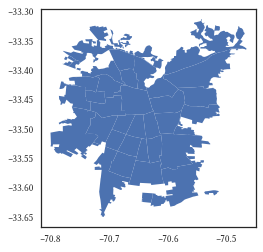

In [3]:
municipalities = gpd.read_file('./intermediate/urban_municipalities.shp').set_index('NOM_COM')
municipalities.plot()

Lo que haremos será enfocarnos en los viajes al trabajo. Contaremos los viajes entre una comuna y otra:

In [4]:
network_data = (df[(df.Proposito == 'Al trabajo') 
                   & (df.ComunaOrigen.isin(municipalities.index))
                   & (df.ComunaDestino.isin(municipalities.index))]
                .groupby(['ComunaOrigen', 'ComunaDestino'])
                .aggregate({'FactorLaboralNormal': 'sum'})
                .reset_index()
                .rename(columns={'FactorLaboralNormal': 'weight'}))
network_data.sample(10)

,ComunaOrigen,ComunaDestino,weight
487,Pedro Aguirre Cerda,Cerro Navia,NaN
760,San Bernardo,La Pintana,1.505878
308,La Pintana,Santiago,77.433145
148,Huechuraba,Las Condes,9.551019
876,Santiago,La Florida,8.317486
388,Lo Espejo,La Pintana,0.817907
520,Peñalolén,Independencia,1.482104
798,San Joaquín,Pedro Aguirre Cerda,2.086147
186,Independencia,Vitacura,1.482104
17,Cerrillos,Pudahuel,4.493860


Haremos una red utilizando el método `from_pandas_edgelist` de `networkx`. Esencialmente, este método asume que cada fila del DataFrame representa una conexión en la red. Los nombres o identificadores de los nodos están implícitos, y solamente podemos asignar atributos a las aristas (en este caso, les daremos un peso).

In [5]:
graph = nx.from_pandas_edgelist(network_data, 
                                source='ComunaOrigen', target='ComunaDestino', 
                                edge_attr='weight',
                                create_using=nx.DiGraph())

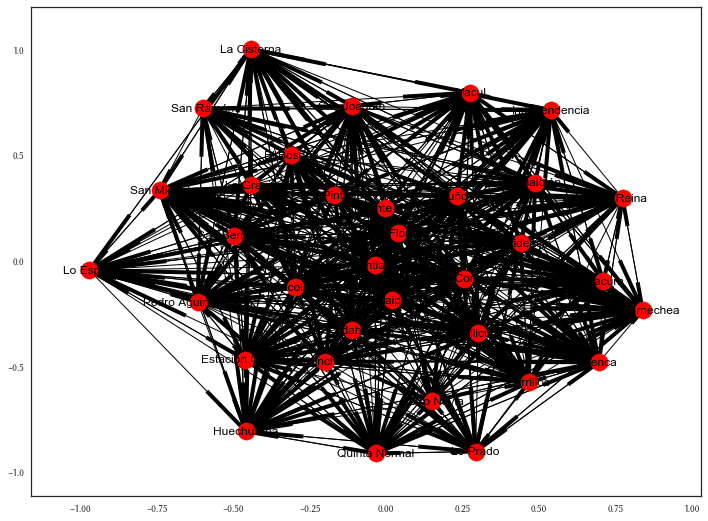

In [6]:
plt.figure(figsize=(12,9))
nx.draw_networkx(graph)

El resultado no es muy bonito. Esto se debe a que posiblemente siempre tendremos al menos una persona que vaya a cualquier combinación posible de comunas de origen y destino. Por ende, tenemos que filtrar. Nos quedaremos con las aristas más frecuentes que el percentil `0.75` de los pesos:

In [7]:
graph = nx.from_pandas_edgelist(network_data[network_data.weight >= network_data.weight.quantile(0.75)], 
                                source='ComunaOrigen', target='ComunaDestino', 
                                edge_attr='weight',
                                create_using=nx.DiGraph())

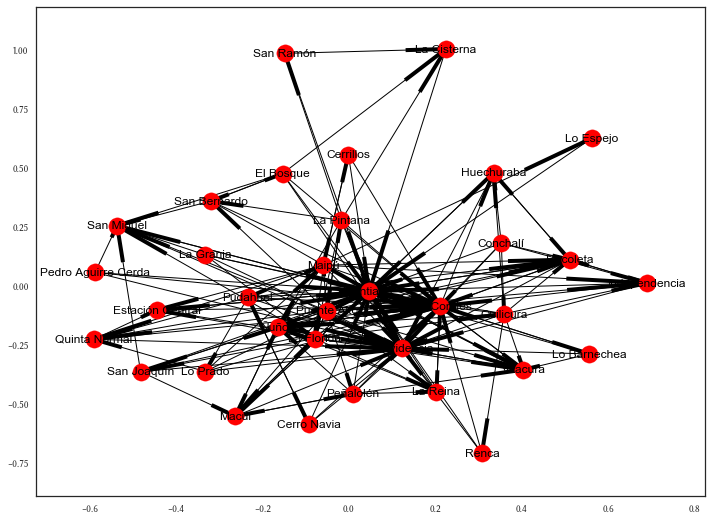

In [8]:
plt.figure(figsize=(12,9))
nx.draw_networkx(graph)

¡Mucho mejor! Se entiende que hay comunas que tienden a concentrar las áreas de trabajo. Ahora bien, aunque la visualización posiciona los nodos utilizando un algoritmo de _layout_ (vean el notebook de Graphtool), en este contexto en particular podemos asignar una posición a cada nodo de acuerdo a la geografía:

In [9]:
centroids = municipalities.centroid
centroids

NOM_COM
Independencia           POINT (-70.66498723527256 -33.4148382467942)
La Florida              POINT (-70.58171845621246 -33.5363205962254)
Lo Barnechea           POINT (-70.51511479085293 -33.34722585571355)
Lo Espejo              POINT (-70.68982492223138 -33.52035931417209)
Lo Prado               POINT (-70.72291782885813 -33.44677411933389)
Pedro Aguirre Cerda    POINT (-70.67545838681376 -33.49175983220304)
Pudahuel               POINT (-70.75849513146272 -33.44111875620347)
San Joaquín            POINT (-70.62840890206175 -33.49609837315337)
San Ramón              POINT (-70.64224345550213 -33.54048398078768)
Puente Alto            POINT (-70.57926834507958 -33.59514505313729)
San Bernardo           POINT (-70.70155343881524 -33.58457996424583)
Cerrillos              POINT (-70.71256495437282 -33.49888338318502)
Cerro Navia             POINT (-70.73887714137881 -33.4227437052342)
Conchalí               POINT (-70.67661144015085 -33.38351699813876)
El Bosque               PO

In [10]:
node_positions = dict(zip(centroids.index, zip(centroids.x, centroids.y)))

La variable `node_positions` es un diccionario que, dado una comuna, me entrega la posición del nodo, que estaba definida como el centroide del polígono de esa comuna:

In [11]:
node_positions['Santiago']

(-70.65641338735794, -33.453539584560275)

También armaremos un vector con los pesos de las aristas. Este vector será transformado utilizando la raíz cuadrada (método `np.sqrt`) para facilitar la discriminación de las aristas:

In [12]:
edge_weight = np.sqrt(np.array([e[2]['weight'] for e in graph.edges(data=True)]))

Dibujemos el grafo ahora:

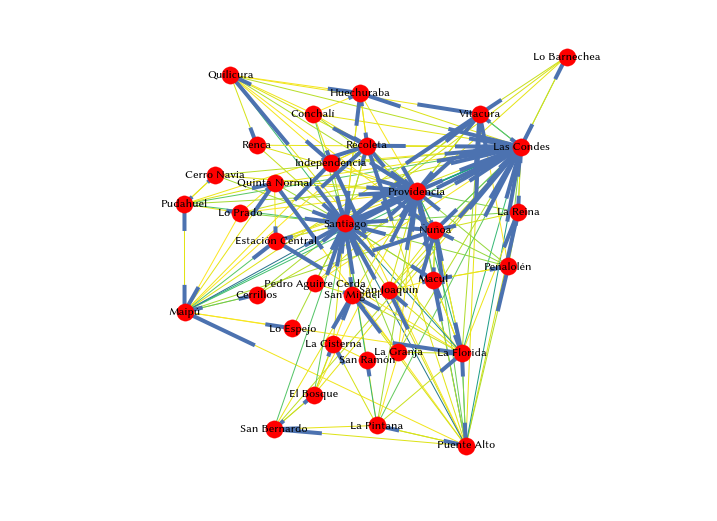

In [13]:
plt.figure(figsize=(12,9))
nx.draw_networkx(graph, pos=node_positions,
                 font_family='Linux Biolinum O',
                 edge_color=edge_weight,
                 edge_vmin=edge_weight.min(),
                 edge_vmax=edge_weight.max(), edge_cmap=plt.cm.viridis_r)
plt.axis('off')
plt.axis('equal');

¡No está mal! Le pusimos color a las aristas (usamos la paleta `viridis`, donde verde oscuro es más peso) y la posición de los nodos es la que corresponde a la geografía, así que es fácil interpretar el grafo.

Por otro lado, las aristas se ven feas, pero esa es una limitación de `networkx`. Por ahora es lo que tenemos.

Una de las características de `networkx` que nos interesa en este notebook es su capacidad de integrarse con `matplotlib`, algo que no realiza `graphtool` (al menos no de manera nativa). Por ejemplo, podemos dibujar el mismo grafo directamente sobre un mapa:

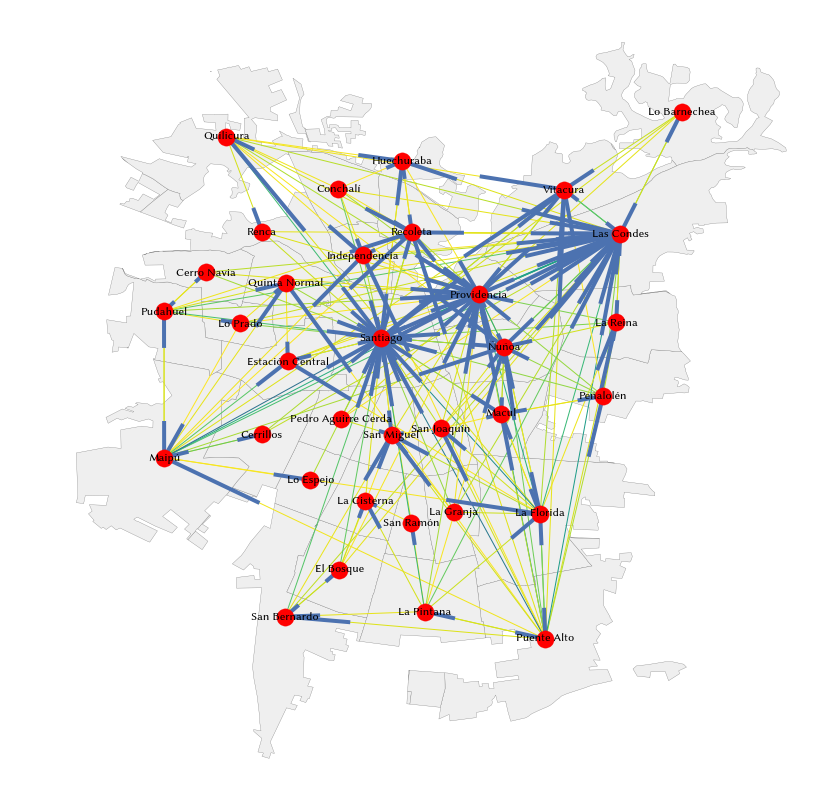

In [14]:
ax = municipalities.plot(figsize=(14,14), facecolor='#efefef', edgecolor='#777777')

nx.draw_networkx(graph, pos=node_positions,
                 font_family='Linux Biolinum O',
                 edge_color=edge_weight,
                 edge_vmin=edge_weight.min(),
                 edge_vmax=edge_weight.max(), edge_cmap=plt.cm.viridis_r)

plt.axis('off')
plt.axis('equal');

Otra manera de visualizar la red que hemos visto antes es la matriz de adyacencia. `networkx` provee una manera fácil de obtener dicha matriz a partir del método `to_numpy_matrix`:

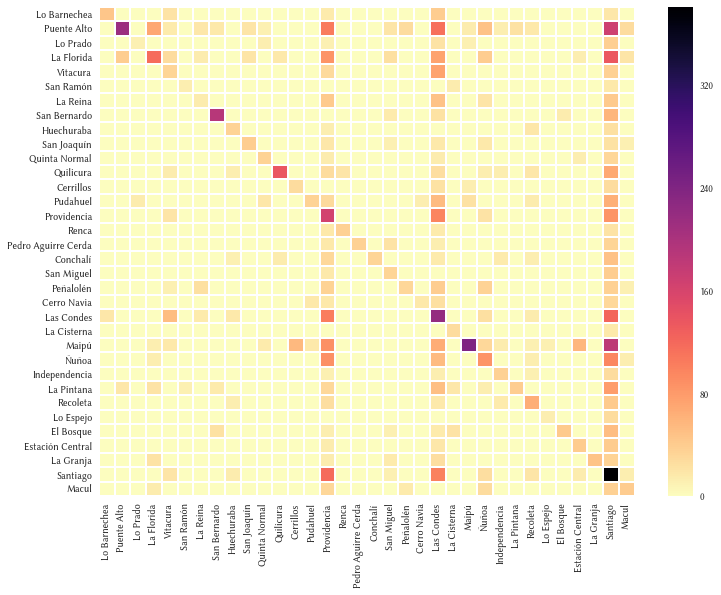

In [15]:
plt.figure(figsize=(12,9))
sns.heatmap(nx.to_numpy_matrix(graph), xticklabels=graph.nodes(), yticklabels=graph.nodes(),
            cmap='magma_r', linewidth=1)

A diferencia de lo que hicimos en notebooks anteriores, esa matriz no está normalizada. Podemos normalizarla por filas de la siguiente manera:

In [16]:
matrix = normalize(nx.to_numpy_matrix(graph), axis=1, norm='l1')

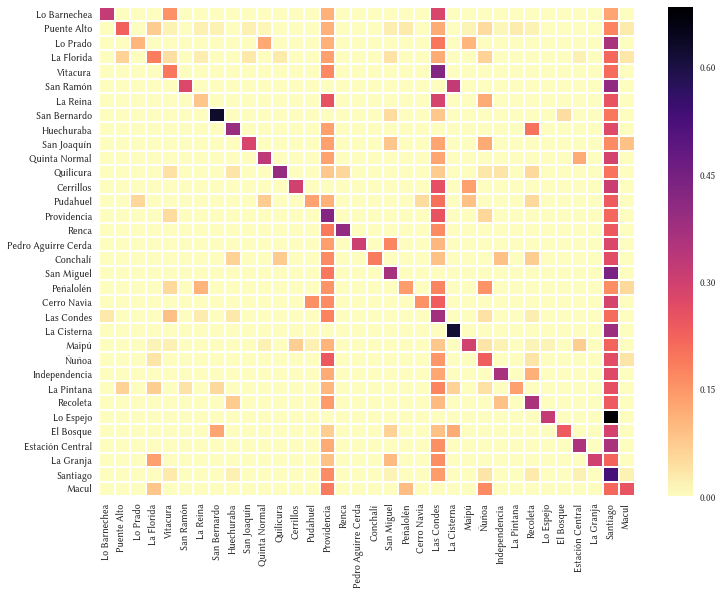

In [17]:
plt.figure(figsize=(12,9))
sns.heatmap(matrix, xticklabels=graph.nodes(), yticklabels=graph.nodes(),
            cmap='magma_r', linewidth=1)

Queda propuesto para les estudiantes ver los parámetros de `to_numpy_matrix` para definir el orden de los nodos.

El último paso es guardar el grafo en un archivo `GraphML`. Lo hacemos con el método `write_graphml`:

In [19]:
nx.write_graphml(graph, './intermediate/test.graphml')